# E-commerce — Выявление профилей потребления

***Задача:*** Провести исследовнаие, сегментировать покупателей по профилю потребления для создание пресонализированных предложений для покупателей.

***Заказчик:*** менеджер продукта, который отвечает за пользовательский опыт.

### Описание данных:

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### Оглавление
- [Загрузка данных](#load)
- [Предобработка данных](#preprocessing)
- [Исследовательский анализ данных](#eda)
 - Разбивка товаров по категориям
 - Исследование выручки и продаж по месяцам
 - Исследование среднего чека в разбивке категорий
 - Исследование выручки в разбивке категорий
 - Выделение топа товаров по количествку
 - Выделение топа товаров по продажам
 - Исследование сезонности категорий товаров
- [Сегментация пользователей](#segmentation)
 - исследование особенностей кластеров пользователей
- [Проверка статистических гипотез](#abtests)
- [Формулирование выводов  и рекомендаций](#conclusion)
- [Материалы исследования(Презентация, дашборд)](#material)

## Загрузка данных
<a id = 'load'></a>

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import OneHotEncoder
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/ecommerce_dataset.csv')

In [3]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [5]:
data.duplicated().sum()

0

Данные загружены, сформирован датасет. Не обнаружено пропусков и дубликатов, необходимо привести колонку даты к соответствующему типу.

## Предобработка данных 
<a id = 'preprocessing'></a>

Приведет колонку 'date' к типу даты, добавим колонки года, недели и месяца, посчитаем выручку, зная цену товара и чисо покупок.

In [6]:
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d%H')

In [7]:
data['year'] = data['date'].dt.year
data['week'] = data['date'].dt.week
data['month'] = data['date'].dt.month

In [8]:
data['cost'] = data['price'] * data['quantity']

In [9]:
data.head()

,date,customer_id,order_id,product,quantity,price,year,week,month,cost
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,40,10,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018,40,10,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,40,10,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,40,10,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,40,10,112.0


Найдем персентили основных признаков, чтобы очистить датасет от аномальных значений

In [10]:
np.percentile(data['price'], [5, 95])

array([  38., 1949.])

In [11]:
np.percentile(data['quantity'], [5, 95])

array([1., 6.])

In [12]:
np.percentile(data['cost'], [5, 99])

array([  38., 5594.])

Очистим датасет по полученным значениям персентилей

In [13]:
data = data.query('price<=1949 & price>38')
data = data.query('quantity<=6')
data = data.query('cost<=1950')

Данные очищены от аномальных значений, добавлены новые признаки, типы колонок приведены в соответсвие с данными. Данные готовы для анализа.

## Исследовательский анализ данных
<a id = 'eda'></a>

Проведем лемматизацию, чтобы выделить категории товаров

In [14]:
data['product'].head()

0      Комнатное растение в горшке Алое Вера, d12, h30
1    Комнатное растение в горшке Кофе Арабика, d12,...
2                          Радермахера d-12 см h-20 см
3                     Хризолидокарпус Лутесценс d-9 см
4                       Циперус Зумула d-12 см h-25 см
Name: product, dtype: object

In [15]:
m = Mystem() 
product_lemm = data.apply(lambda row: m.lemmatize(row['product']), axis=1)

In [16]:
mas_lemm = []
for elem in product_lemm:
    mas_lemm.extend(elem)

In [17]:
#pprint.pprint(Counter(list(filter(lambda x: len(x) > 4 and ~x.isdigit(), [i for i in mas_lemm]))))

In [18]:
category_dict = {
    'растения': ['рассада', 'пеларгония', 'кабачок', 'зелень', 'огурец', 'томат', 'петуния', 'помидор', 'растение',
                'крупноцветковый', 'цветок', 'капуста', 'тагетис', 'однолетний', 'арбуз', 'вербена', 'герань',
                'тыква', 'базилик', 'лобелия', 'клубника', 'флокс', 'цикламен', 'гунни', 'циперус', 'груша', 
                'зумула', 'фиалка', 'баклажан', 'плющелистный', 'тюльпановидный', 'персик', 'бегония', 'тимьян', 
                'виола', 'виноград', 'пуансеттия', 'розебудный', 'комнатный', 'растение', 'калибрахоа'],
    'хоз товары': ['тележка', ' сушилка', 'доска', 'гладильный', 'стремянка', 'сумка', 'кухонный', 'унитазный', 'скатерть',
                  ],
    'посуда': ['тарелка', 'набор', 'салатник', 'обеденный', 'десертный', 'набор'],
    'интерьер': ['корзина', 'кашпо', 'муляж', 'коврик', 'домашний', 'искусственный', 'коврик', 'штора', 'вешалка', 
                 'декоративная', 'комод','покрывало', 'одеяло', 'фоторамка','этажерка', 'полки', 'кухонное','подарочный',
                 'наматрацник', 'стеллаж', 'складной',
                ],
    'техника': ['миксер', 'чайник', 'весы', 'пылесос', 'утюг', 'кипятильник', 'соковыжималка', 'кипятильник', 'фен'],
}

In [19]:
def category(lemm_str):
    for key, value in category_dict.items():
        for value_word in value:
            if value_word in lemm_str:
                return key
    return 'другое'

In [20]:
data['category'] = product_lemm.apply(category)

In [21]:
data['category'].value_counts()

растения      3005
другое        1436
хоз товары     611
интерьер       343
посуда          92
техника         33
Name: category, dtype: int64

In [22]:
data.head()

,date,customer_id,order_id,product,quantity,price,year,week,month,cost,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,40,10,142.0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018,40,10,194.0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,40,10,112.0,другое
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,40,10,179.0,другое
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,40,10,112.0,растения


In [23]:
rev_catseason = data.groupby(['month', 'category']).agg({'customer_id':'nunique',
                                                         'quantity': 'sum',
                                                         'cost':'sum'})
rev_catseason

customer_id  quantity     cost
month category                                  
1     другое               55        87  31193.0
      интерьер             18        27  14813.0
      посуда                5        18   5307.0
      растения             18        58  11369.0
      техника               4         4   3604.0
...                       ...       ...      ...
12    интерьер             28        39  24235.0
      посуда               11        38  13197.0
      растения             22        47   9048.0
      техника               3         5   4196.0
      хоз товары           48        77  73649.0

[70 rows x 3 columns]

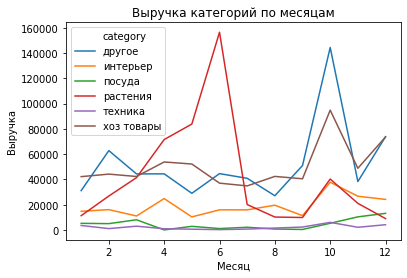

In [24]:
sns.lineplot(x = 'month', y = 'cost', hue = 'category', data = rev_catseason.reset_index())
plt.title('Выручка категорий по месяцам')
plt.ylabel('Выручка')
plt.xlabel('Месяц')
plt.show()

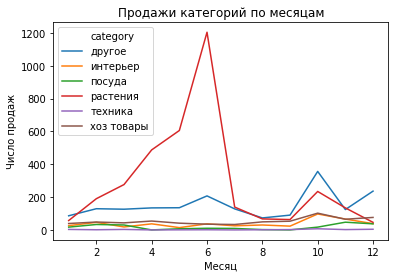

In [25]:
sns.lineplot(x = 'month', y = 'quantity', hue = 'category', data = rev_catseason.reset_index())
plt.title('Продажи категорий по месяцам')
plt.ylabel('Число продаж')
plt.xlabel('Месяц')
plt.legend (loc='upper left')
plt.show()

In [26]:
order_group = data.groupby('order_id').agg({'customer_id':'first',
                                            'product':'count',
                                            'price':['mean','sum'],
                                            'category': lambda x:x.value_counts().index[0],
                                            'date':'first'}).reset_index()
order_group.columns = ['order_id', 'customer_id', 'product_count', 'mean_price', 'sum_price', 'category' ,'date']

In [27]:
average_check_cat = order_group.groupby('category').agg({'product_count':'sum','sum_price':'sum'})
average_check_cat['mean'] = average_check_cat['sum_price']/average_check_cat['product_count']
average_check_cat = average_check_cat.sort_values(by = 'mean', ascending = False)
average_check_cat

,product_count,sum_price,mean
category,,,
хоз товары,597,582047.0,974.953099
техника,36,24706.0,686.277778
интерьер,314,194038.0,617.955414
другое,1413,578530.0,409.433829
посуда,84,28694.0,341.595238
растения,3076,445411.0,144.802016


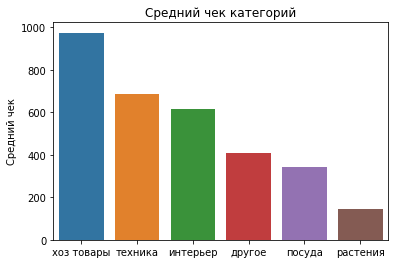

In [28]:
sns.color_palette("pastel")
sns.barplot(x = 'category', y = 'mean', data = average_check_cat.reset_index())
plt.title('Средний чек категорий')
plt.ylabel('Средний чек')
plt.xlabel('')
plt.show()

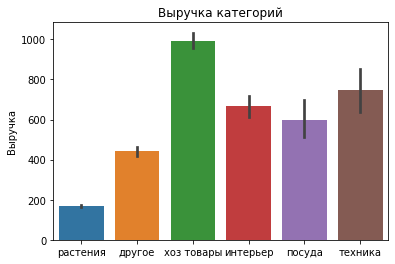

In [29]:
sns.barplot(x = 'category', y = 'cost', data = data)
plt.title('Выручка категорий')
plt.ylabel('Выручка')
plt.xlabel('')
plt.show()

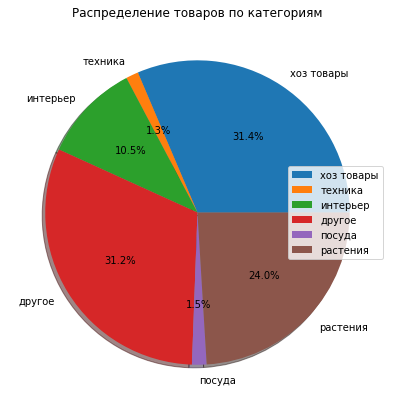

In [30]:
average_check_cat['sum_price'].plot.pie(subplots=True, shadow = True, autopct='%1.1f%%', figsize=(7, 7))
plt.title('Распределение товаров по категориям')
plt.legend (loc='right')
plt.ylabel('')
plt.show()

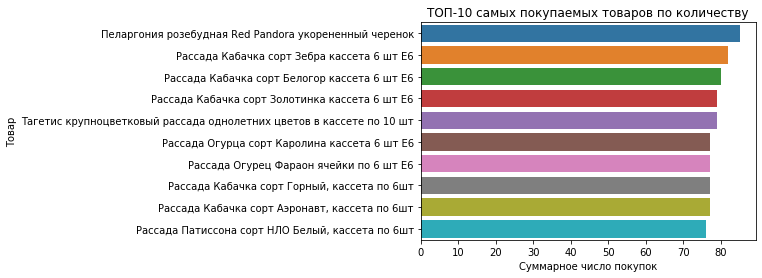

In [31]:
sns.barplot(x = 'quantity',y = 'product',
            data=data.groupby('product').agg({'quantity':'sum'}).sort_values(
                by = 'quantity', ascending = False).iloc[:10].reset_index())
plt.title('ТОП-10 самых покупаемых товаров по количеству')
plt.xlabel('Суммарное число покупок') 
plt.ylabel('Товар')
plt.show()

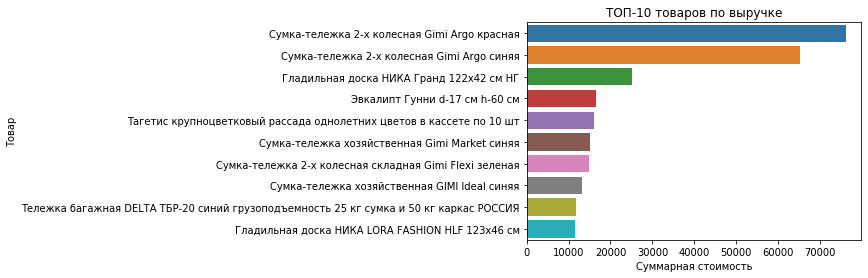

In [32]:
sns.barplot(x = 'price',y = 'product',
            data=data.groupby('product').agg({'price':'sum'}).sort_values(
                by = 'price', ascending = False).iloc[:10].reset_index())
plt.title('ТОП-10 товаров по выручке')
plt.xlabel('Суммарная стоимость') 
plt.ylabel('Товар')
plt.show()

Добавим признак сезона, чтобы исследовать сезонность продаж в группах товаров

In [33]:
def season(row):
    if  3 <= int(row['month']) <= 5:
        return 'весна'
    elif 6 <= int(row['month']) <= 8:
        return 'лето'
    elif 9 <= int(row['month']) <= 11:
        return 'осень'
    else:
        return 'зима'

In [34]:
data['season'] = data.apply(season, axis = 1)

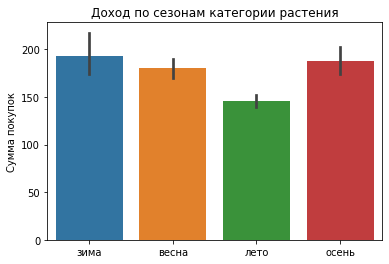

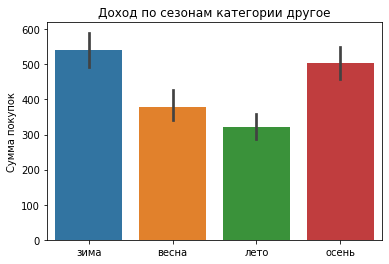

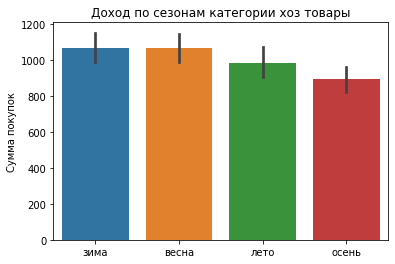

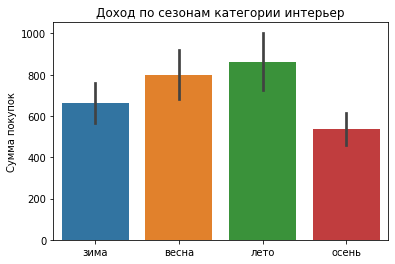

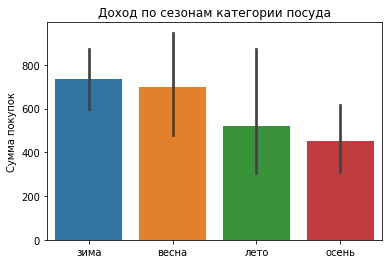

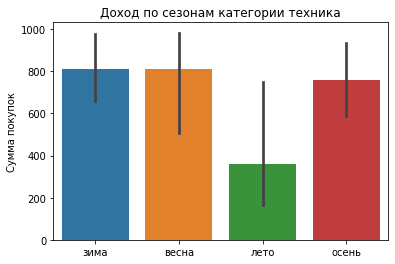

In [35]:
for category in data['category'].unique():
    sns.barplot(x = 'season', y = 'cost',  order = ['зима','весна','лето','осень'], data = data.query('category==@category'))
    plt.title('Доход по сезонам категории {}'.format(category))
    plt.ylabel('Сумма покупок')
    plt.xlabel('')
    plt.show()

Сделаем выводы о сезонности покупок: осенью и зимой покупают растения и технику, выручка от хоз товаров не сильно различается по сезонам, посуду чаще берут зимой и весной, товары для интерьера покупают летом, технику тоже берут зимой и осенью.

Исследовали выручку и продажи категорий по месяцам, неприрывно до июня растут продажи категории растения и выручка от них, после наблюдаем резкое снижене. В ноябре налюдаем всплеск выручки от продаж хоз товаров. Максимальный средний чек и выручка у категории хоз товаров. На втором месте по выручке техника, на третьем интерьер. 
Мы распределили товары на 6 категорий, 32 процента составляют хоз товары, 24% растения, 11% интерьер, 1.5% техника, 1.3% посуда, у 30% не определили категорию.
В топ 10 товаров по продажам находятся рассады - товары категории растения. В топ 10 по выручке большинство товаров - хозяйственные сумки и тележки.

Выводы о сезонности покупок: осенью и зимой покупают растения и технику, выручка от хоз товаров не сильно различается по сезонам, посуду чаще берут зимой и весной, товары для интерьера покупают летом, технику тоже берут зимой и осенью.

## Сегментация пользователей
<a id = 'segmentation'></a>

In [36]:
data.head()

,date,customer_id,order_id,product,quantity,price,year,week,month,cost,category,season
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,40,10,142.0,растения,осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018,40,10,194.0,растения,осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,40,10,112.0,другое,осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,40,10,179.0,другое,осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,40,10,112.0,растения,осень


Выделим категории в отдельные колонки, создадим бинарные переменные, чтобы учесть их в кластеризации

In [37]:
enc = OneHotEncoder(handle_unknown = 'ignore')
feature_arr = enc.fit_transform(data[['category']]).toarray()
feature_labels = enc.categories_

In [38]:
data_features = pd.DataFrame(feature_arr, columns=feature_labels)
data_features = data_features.astype(int)
data = data.reset_index().drop(['index'], axis = 1).join(data_features)

In [39]:
data.columns

Index([         'date',   'customer_id',      'order_id',       'product',
            'quantity',         'price',          'year',          'week',
               'month',          'cost',      'category',        'season',
           ('другое',),   ('интерьер',),     ('посуда',),   ('растения',),
          ('техника',), ('хоз товары',)],
      dtype='object')

In [40]:
df_cluster = data.groupby('customer_id').agg({'order_id':'nunique',
                                              'quantity':'mean',
                                              'cost':'sum', 
                                             ('другое',):'sum',
                                             ('интерьер',):'sum',
                                             ('посуда',):'sum',
                                             ('растения',):'sum',
                                             ('хоз товары',):'sum'})
df_cluster.head()

,order_id,quantity,cost,"(другое,)","(интерьер,)","(посуда,)","(растения,)","(хоз товары,)"
customer_id,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,1,1.0,555.0,0,0,0,4,0
001cee7f-0b29-4716-b202-0042213ab038,1,1.0,442.0,1,0,0,0,0
00299f34-5385-4d13-9aea-c80b81658e1b,1,2.0,914.0,1,0,0,0,0
002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1649.0,0,0,0,0,1
005ba170-45e8-42de-93f7-192481ae2659,1,1.0,1199.0,0,1,0,0,0


In [41]:
np.percentile(df_cluster['cost'], [5, 99])

array([  88.  , 5432.79])

Очистим датастет от выбросов, для лучшего распределения кластеров

In [42]:
df_cluster = df_cluster.query('cost<=5433 & cost>88')

In [43]:
x = df_cluster.reset_index().drop(['customer_id'], axis = 1)
scaler = StandardScaler() 
# обязательная стандартизация данных перед работой с алгоритмами
x_sc = scaler.fit_transform(x)

In [44]:
linked = linkage(x_sc, method = 'ward')

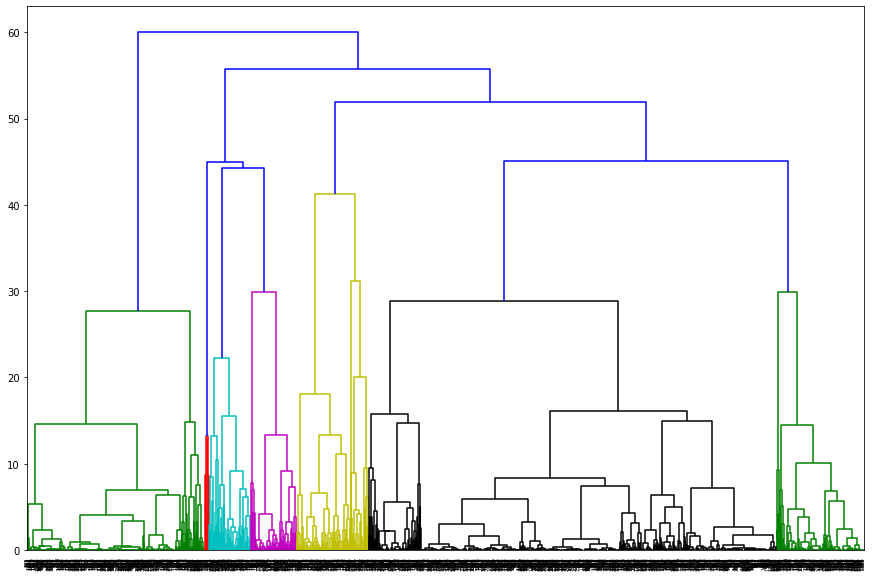

In [45]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.xlabel('')
plt.show()

In [46]:
# задаём модель k_means с числом кластеров 7
km = KMeans(n_clusters = 7, random_state = 0)
labels = km.fit_predict(x_sc)
df_cluster['cluster'] = labels
df_cluster.cluster.value_counts()

0    960
1    394
5    207
3    100
2     86
6     74
4     11
Name: cluster, dtype: int64

In [47]:
df_cluster.groupby('cluster').mean().T

cluster,0,1,2,3,4,5,6
order_id,1.000000,1.025381,2.209302,1.010000,1.454545,1.033816,1.108108
quantity,1.191192,1.049704,1.184593,4.294167,1.391252,1.185829,1.177077
cost,582.494792,1152.634518,1075.360465,999.230000,3200.545455,1003.584541,1966.364865
"(другое,)",0.812500,0.083756,1.000000,0.460000,14.818182,0.130435,0.702703
"(интерьер,)",0.000000,0.007614,0.139535,0.140000,0.000000,1.309179,0.013514
"(посуда,)",0.018750,0.000000,0.058140,0.610000,0.181818,0.009662,0.000000
"(растения,)",0.689583,0.022843,2.325581,0.330000,3.727273,0.164251,11.878378
"(хоз товары,)",0.000000,1.152284,0.151163,0.000000,0.000000,0.000000,0.000000


Клиенты кластера 0 характеризует низкая средней стоимостью заказа, совершили 1 заказ в основном с 1 товаром. Кластер 1 характеризуется совершением клиентами по 1 закзу с 1 наименованием, но высокой стоимости, чаще покупаются хоз товары. Кластер 2 характеризует совершение более 2 заказов, основная категория покупок растения и другое. Клиенты кластера 3 совершили по 1 заказу в среднем с более 4 товарами. К кластеру 4 относятся клиенты, совершающие покупки категории другое с наивысшей стоимостью. К кластеру 5 относим пользователей с небольними покупками категории интерьер. Кластер 6 - пользователи, покупающие много растений. 

## Проверка статистических гипотез
<a id = 'abtests'></a>

Проверим гипотезу о равенстве выручки кластеров  
H0 - выручка кластеров A и B равны  
H1 - вырчка кластров A и B не равна  

In [48]:
cluster0 = df_cluster.query('cluster==0')['cost']
cluster1 = df_cluster.query('cluster==1')['cost']
cluster2 = df_cluster.query('cluster==2')['cost']
cluster3 = df_cluster.query('cluster==3')['cost']
cluster4 = df_cluster.query('cluster==4')['cost']
cluster5 = df_cluster.query('cluster==5')['cost']
cluster6 = df_cluster.query('cluster==6')['cost']

Часть выборок имеют малый размер, в качестве стат критерия будем использоват критерий Манна-Уитни

In [49]:
mas_cluster = [cluster0, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6]
mas_cluster_str = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']
for index_one in range(len(mas_cluster)):
    for index_two in range(index_one+1, len(mas_cluster)):
        p_mw = st.mannwhitneyu(mas_cluster[index_one], mas_cluster[index_two], alternative = 'two-sided' )[1]
        print('Кластеры',mas_cluster_str[index_one], mas_cluster_str[index_two])
        print('p_value: {:.5f}'.format(p_mw))
        print('Средняя выручка кластера A: {:.0f}'.format(mas_cluster[index_one].mean()))
        print('Средняя выручка кластера B: {:.0f}'.format(mas_cluster[index_two].mean()))
        if p_mw<0.05:
            print('Гипотеза H0 о равенстве выручки кластеров отвергается\n')
        else:
            print('Гипотеза H0 о равенстве выручки кластеров не отвергается\n')

Кластеры cluster0 cluster1
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 1153
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster0 cluster2
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 1075
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster0 cluster3
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 999
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster0 cluster4
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 3201
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster0 cluster5
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 1004
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster0 cluster6
p_value: 0.00000
Средняя выручка кластера A: 582
Средняя выручка кластера B: 1966
Гипотеза H0 о равенстве выручки кластеров отвергается

Кластеры cluster1

Проверив гипотезы, вы выявили, что попарная выручка кластеров 1 и 2, 2 и 3, 2 и 5, 3 и 5 равна


## Формулирование выводов
<a id = 'conclusion'></a>

Мы загрузили данные и очистили от аномальных значений, добавлены новые признаки, типы колонок привели к необходимым.  

Провели лемматизацию и выделили типы товаров. Исследовали выручку и продажи категорий по месяцам, непрерывно до июня растут продажи категории растения и выручка от них, после наблюдаем резкое снижене. В ноябре налюдаем всплеск выручки от продаж хоз товаров. Максимальный средний чек и выручка у категории хоз товаров. На втором месте по выручке техника, на третьем интерьер. Мы распределили товары на 6 категорий, 32 процента составляют хоз товары, 24% растения, 11% интерьер, 1.5% техника, 1.3% посуда, у 30% не определили категорию. В топ 10 товаров по продажам находятся рассады - товары категории растения. В топ 10 по выручке большинство товаров - хозяйственные сумки и тележки.

Выводы о сезонности покупок: осенью и зимой покупают растения и технику, выручка от хоз товаров не сильно различается по сезонам, посуду чаще берут зимой и весной, товары для интерьера покупают летом, технику тоже берут зимой и осенью.

Сегментировали клиентов и выделили 7 кластеров. Клиенты кластера 0 характеризует низкая срежней стоимостью заказа, совершили 1 заказ в основном с 1 товаром. Кластер 1 характеризуется совершением клиентами по 1 закзу с 1 наименованием, но высокой стоимости, чаще покупаются хох товары. Кластер 2 характеризует совершение более 2 заказов, основная категория покупок растения и другое. Клиенты кластера 3 совершили по 1 заказу в среднем с более 4 товарами. К кластеру 4 относятся клиенты, совершающие покупк категории другое с наивсшей стоимостью. К кластеру 5 относим пользователй с небольними покупками категории интерьер. Кластер 6 - пользователи, покупающие много растений.

## Материалы исследования
<a id = 'material'></a>

* [Презентация](https://drive.google.com/file/d/17wm3umV81EHfWw7qxig6uW0qC4GjRNri/view?usp=sharing)  
* [Дашборд](https://public.tableau.com/profile/dmitry8264#!/vizhome/Book1_16188514871640/Dashboard2?publish=yes)